In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import date
from tqdm.notebook import tqdm
from scipy.sparse import hstack, vstack
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, confusion_matrix, f1_score, roc_curve, auc, balanced_accuracy_score, matthews_corrcoef
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [3]:
df = pd.read_csv('processed/3_scaled_data.csv')

In [4]:
df.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,...,PotentialFraud,isDead,Age,AdmitPeriod,ClaimPeriod,Physician_Same,DiseasesCount,PhysiciansCount,TotalClaimCodes,TotalClaimProcedures
0,6.542662,3.614518,1,1,0,39,230,12,12,1,...,1,0,-0.559101,2.645553,0.870964,4,1.072497,-0.579855,2.448874,-0.190910
1,-0.247810,-0.285942,1,1,0,39,310,12,12,1,...,1,0,0.286303,-0.194426,-0.352283,4,-0.213787,1.399303,2.448874,-0.190910
2,4.710935,3.614518,2,1,0,39,230,12,12,1,...,1,0,1.746548,5.485532,2.094211,4,0.214974,3.378460,2.448874,6.938348
3,4.187585,3.614518,1,1,0,39,600,12,12,0,...,1,0,1.054853,8.325512,3.317457,1,-1.071310,-0.579855,2.448874,3.373719
4,3.140884,3.614518,2,1,0,39,280,12,12,0,...,1,0,0.440013,1.698893,0.463215,4,0.643736,3.378460,1.631441,3.373719


In [5]:
# check the target variable
df['PotentialFraud'].value_counts()

PotentialFraud
0    345415
1    212796
Name: count, dtype: int64

#### Split the data

In [6]:
Y = df['PotentialFraud']
X = df.drop(columns=['PotentialFraud'])

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(446568, 33) (111643, 33) (446568,) (111643,)


In [9]:
# performance
def plotPerformance(yActual, yPred):
    # Get Confusion Matrix based on the input 'yActual' and 'yPred'.
    confusionMatrix = confusion_matrix(y_true=yActual, y_pred=yPred)
    
    plt.figure(figsize=(6, 4))
    
    # Plot the Confusion Matrix.
    sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Reds')
    plt.title('Confusion Matrix on Test Data', fontsize=20)
    plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
    plt.ylabel('Actual Values', fontsize=15) # Label on the y-axis
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-fraud)', 'Predicted: YES (Fraud)'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Actual: NO (Non-fraud)', 'Actual: YES (Fraud)'], rotation=0)
    
    # Find Total Negatives and Total Positives (Actual/ ground truth)
    totalNegative, totalPositive = tuple(confusionMatrix.sum(axis=1))
    
    # Find True Positive, False Positive, False Negative and True Positive
    tn, fp, fn, tp = confusionMatrix.ravel()
    
    # Calculate the FPR and FNR
    fpr = fp / totalNegative
    fnr = fn / totalPositive
    print('False Positive Rate (FPR) on Test Data: ', fpr)
    print('False Negative Rate (FNR) on Test Data: ', fnr)
    
    # Get the BACC Score
    bacc = balanced_accuracy_score(y_true=yActual, y_pred=yPred)
    print('Balanced Accuracy Score (BACC) on Test Data: ', bacc)
    

In [10]:
def getProbabilityEstimates(yPredProb, positiveClass=True, batchSize=1000):
    # Check if the input Predicted variable is a Probabilty Estimates or not
    if len(yPredProb.shape) == 1:
        print('Pass the Probability Estimates')
        return
    
    probEstimates = list() # Variable to store the Predicted Probability Estimates
    classIndex = 1 # Index of the Class (For -ve class, it should be 0 and for +ve class, it should be 1)
    if positiveClass == False:
        classIndex = 0
    batchsize = batchSize # Process a batch of given size.
    totalCnt = yPredProb.shape[0] # Total number of Datapoints
    datapointCount = totalCnt - totalCnt%batchsize # Total no. of datapoints minus the last batch of datapoint
    
    # Loop through the dataset batch-wise
    for i in range(0, datapointCount, batchsize):
        probEstimates.extend(yPredProb[i : i + batchsize][:,classIndex]) # Add Probability Estimates of +ve class
        
    # Find the Probability Estimate for the remaining last batch
    if totalCnt%batchsize != 0:
        probEstimates.extend(yPredProb[datapointCount:][:,classIndex])
    
    return probEstimates

In [11]:
# plot AUC-ROC
def plotROC(yTestActual, yTestPredProb, yTrainActual=None, yTrainPredProb=None):
    # Check if the input Predicted variable is a Probabilty Estimates or not
    if len(yTestPredProb.shape) == 1:
        print('Pass the correct Probability Estimates')
        return
    
    # Calculate the Predicted Probability Estimates for the positive class of Test Data
    yTestPredPE = getProbabilityEstimates(yTestPredProb)
    
    # Find the FPR, TPR and Threshold values for the Test Data
    fprTest, tprTest, thresholdTest = roc_curve(yTestActual, yTestPredPE)
    
    # Find the AUC
    areaTest = auc(fprTest, tprTest)

    # If Train Dataset to also to be considered for plotting ROC
    if (type(yTrainActual) != type(None) and type(yTrainPredProb) != type(None)):

        # Check if the input Predicted variable is a Probabilty Estimates or not
        if len(yTrainPredProb.shape) == 1:
            print('Please pass the correct Probability Estimates')
            return
        
        # Calculate the Predicted Probability Estimates for the positive class of Train Data
        yTrainPredPE = getProbabilityEstimates(yTrainPredProb)
        
        # Find the FPR, TPR and Threshold values for the Train Data
        fprTrain, tprTrain, thresholdTrain = roc_curve(yTrainActual, yTrainPredPE)
        
        # Find the AUC
        areaTrain = auc(fprTrain, tprTrain)
    
    # Plot the ROC Curve
    # If Train Dataset to also to be considered for plotting ROC
    if (type(yTrainActual) != type(None) and type(yTrainPredProb) != type(None)):

        plt.plot(fprTrain, tprTrain, label= 'Train AUC: ' + str(areaTrain))

    plt.plot(fprTest, tprTest, label= 'Test AUC: ' + str(areaTest))
    plt.legend()
    # If Train Dataset to also to be considered for plotting ROC
    if (type(yTrainActual) != type(None) and type(yTrainPredProb) != type(None)):

        plt.title('ROC Curve of Train and Test Data', fontsize=20)

    else:

        plt.title('ROC Curve of Test Data', fontsize=20)

    plt.xlabel('FPRs', fontsize=15)
    plt.ylabel('TPRs', fontsize=15)
    plt.grid()
    plt.show()

#### 1. Naive Bayes

In [12]:
# Using Naive Bayes

# Create a Naive Bayes model
nb_model = GaussianNB()

# Train the model on the training data
nb_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6250996479850953
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.91      0.75     69277
           1       0.52      0.15      0.24     42366

    accuracy                           0.63    111643
   macro avg       0.58      0.53      0.49    111643
weighted avg       0.59      0.63      0.56    111643



False Positive Rate (FPR) on Test Data:  0.08705631017509419
False Negative Rate (FNR) on Test Data:  0.8455837227965821
Balanced Accuracy Score (BACC) on Test Data:  0.5336799835141618


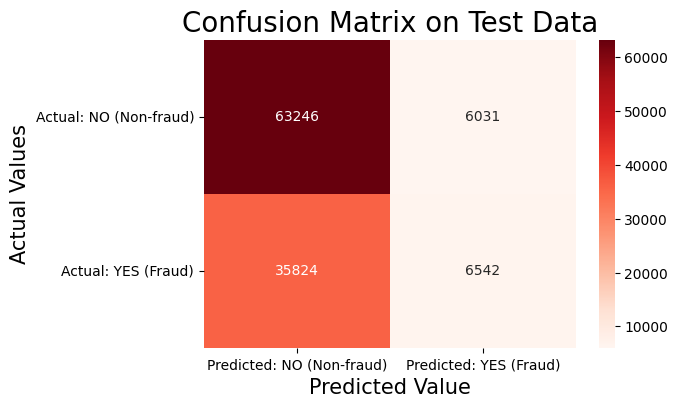

In [13]:
# Plot the confusion matrix
plotPerformance(y_test, y_pred)

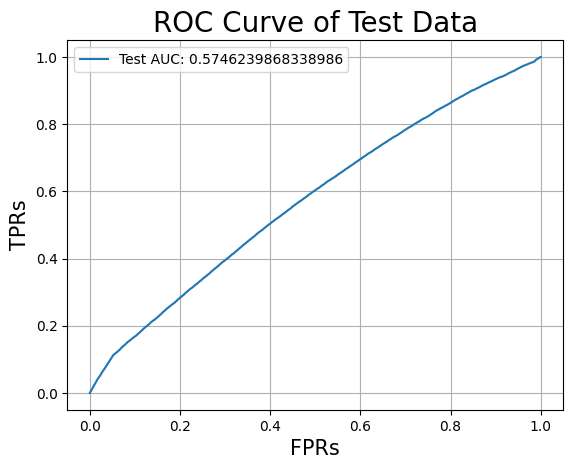

In [14]:
# plot the ROC curve
plotROC(y_test, nb_model.predict_proba(X_test))

#### 2. Logistic Regression

In [15]:
# Using Logistic Regression

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(random_state=42)

# Train the model on the training data
logistic_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6287093682541673
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.94      0.76     69277
           1       0.55      0.11      0.19     42366

    accuracy                           0.63    111643
   macro avg       0.59      0.53      0.47    111643
weighted avg       0.60      0.63      0.54    111643



/Users/amilaviraj/anaconda3/envs/vis_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


False Positive Rate (FPR) on Test Data:  0.0551553906780028
False Negative Rate (FNR) on Test Data:  0.8882358495019591
Balanced Accuracy Score (BACC) on Test Data:  0.528304379910019


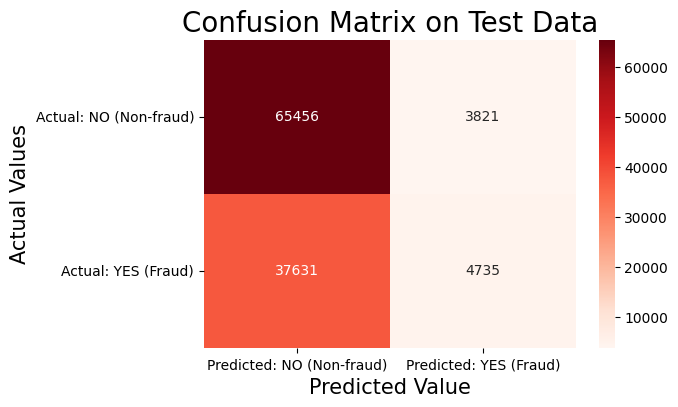

In [16]:
plotPerformance(y_test, y_pred)

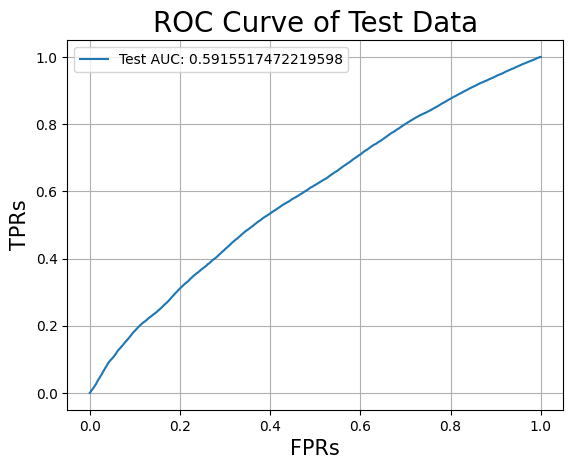

In [17]:
plotROC(y_test, logistic_model.predict_proba(X_test))

#### 3. Decision Tree

In [18]:
# Using Decision Tree

# Initialize the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
decision_tree_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7008589880243276
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     69277
           1       0.60      0.61      0.61     42366

    accuracy                           0.70    111643
   macro avg       0.68      0.68      0.68    111643
weighted avg       0.70      0.70      0.70    111643



False Positive Rate (FPR) on Test Data:  0.24373168584089958
False Negative Rate (FNR) on Test Data:  0.3897464948307605
Balanced Accuracy Score (BACC) on Test Data:  0.68326090966417


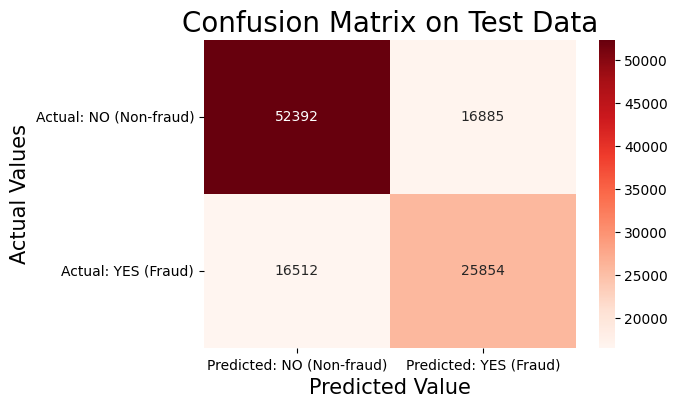

In [19]:
# Plot the performance
plotPerformance(y_test, y_pred)

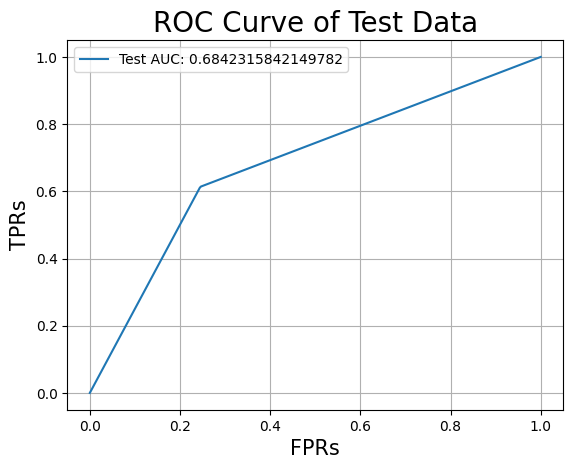

In [20]:
# Plot the ROC curve
plotROC(y_test, decision_tree_model.predict_proba(X_test))

#### 4. Random Forest

In [21]:
# Using Random Forest

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
random_forest_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = random_forest_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7252492319267666
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79     69277
           1       0.67      0.54      0.60     42366

    accuracy                           0.73    111643
   macro avg       0.71      0.69      0.70    111643
weighted avg       0.72      0.73      0.72    111643



False Positive Rate (FPR) on Test Data:  0.16418147437100336
False Negative Rate (FNR) on Test Data:  0.4555539819666714
Balanced Accuracy Score (BACC) on Test Data:  0.6901322718311627


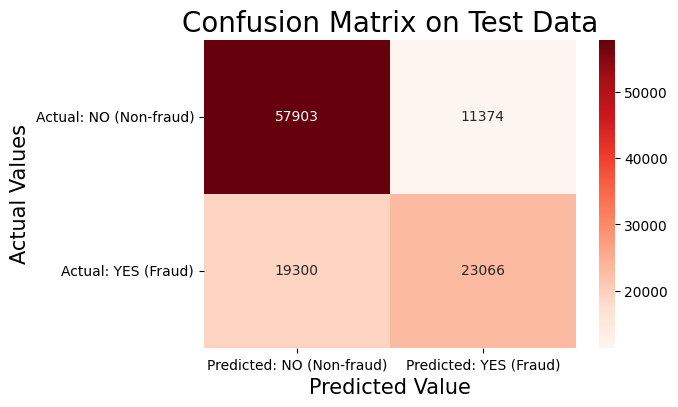

In [22]:
# Plot the performance
plotPerformance(y_test, y_pred)

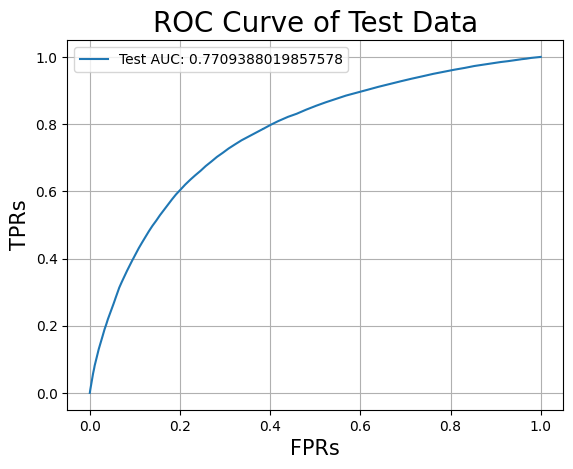

In [23]:
# Plot the ROC curve
plotROC(y_test, random_forest_model.predict_proba(X_test))

#### 5. XGBoost

In [24]:
# Using XGBoost

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7671506498392197
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82     69277
           1       0.74      0.60      0.66     42366

    accuracy                           0.77    111643
   macro avg       0.76      0.74      0.74    111643
weighted avg       0.76      0.77      0.76    111643



False Positive Rate (FPR) on Test Data:  0.13209290240628202
False Negative Rate (FNR) on Test Data:  0.3976065713071803
Balanced Accuracy Score (BACC) on Test Data:  0.7351502631432689


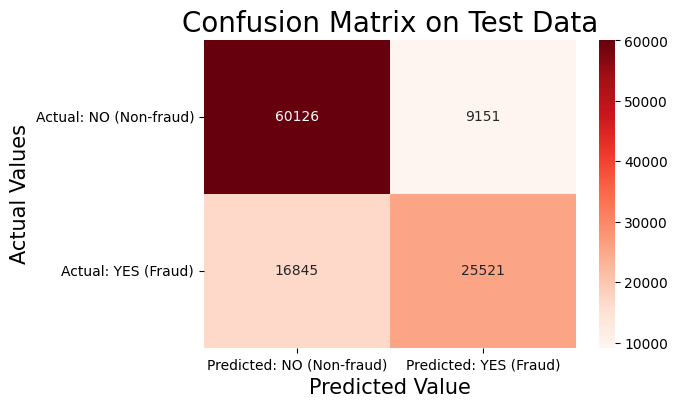

In [25]:
# Plot the performance
plotPerformance(y_test, y_pred)

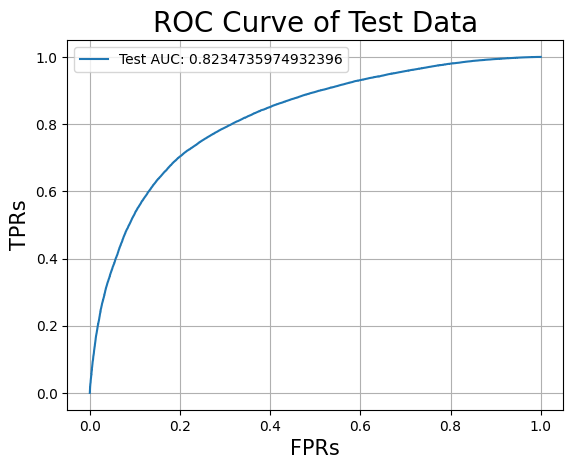

In [26]:
# Plot the ROC curve
plotROC(y_test, xgb_model.predict_proba(X_test))

#### 6. LightGBM

In [27]:
# Using LightGBM

# Initialize the LightGBM model
lgbm_model = LGBMClassifier(random_state=42)

# Train the model on the training data
lgbm_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = lgbm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 170430, number of negative: 276138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1596
[LightGBM] [Info] Number of data points in the train set: 446568, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381644 -> initscore=-0.482576
[LightGBM] [Info] Start training from score -0.482576
Accuracy: 0.7490393486380695
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.81     69277
           1       0.73      0.54      0.62     42366

    accuracy                           0.75    111643
   macro avg       0.74      0.71      0.72    111643
weighted avg       0.75      0.75      0.74    111643



False Positive Rate (FPR) on Test Data:  0.12165653824501638
False Negative Rate (FNR) on Test Data:  0.46239909361280274
Balanced Accuracy Score (BACC) on Test Data:  0.7079721840710904


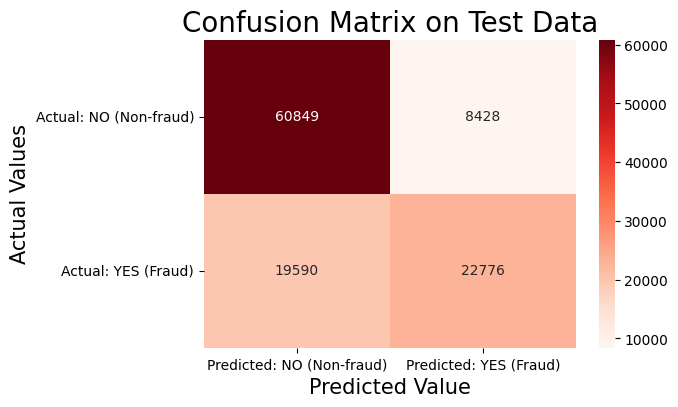

In [28]:
# Plot the performance
plotPerformance(y_test, y_pred)

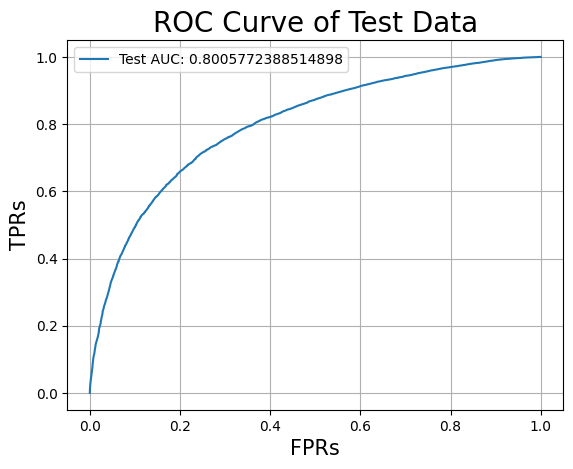

In [29]:
# Plot the ROC curve
plotROC(y_test, lgbm_model.predict_proba(X_test))

In [30]:
# Compare different accuracy metrics for all the developed above models and create a df table
accuracy = []
f1 = []
bacc = []
mcc = []

# Naive Bayes
y_pred = nb_model.predict(X_test)
accuracy.append(accuracy_score(y_test, y_pred))
f1.append(f1_score(y_test, y_pred))
bacc.append(balanced_accuracy_score(y_test, y_pred))
mcc.append(matthews_corrcoef(y_test, y_pred))

# Logistic Regression
y_pred = logistic_model.predict(X_test)
accuracy.append(accuracy_score(y_test, y_pred))
f1.append(f1_score(y_test, y_pred))
bacc.append(balanced_accuracy_score(y_test, y_pred))
mcc.append(matthews_corrcoef(y_test, y_pred))

# Decision Tree
y_pred = decision_tree_model.predict(X_test)
accuracy.append(accuracy_score(y_test, y_pred))
f1.append(f1_score(y_test, y_pred))
bacc.append(balanced_accuracy_score(y_test, y_pred))
mcc.append(matthews_corrcoef(y_test, y_pred))

# Random Forest
y_pred = random_forest_model.predict(X_test)
accuracy.append(accuracy_score(y_test, y_pred))
f1.append(f1_score(y_test, y_pred))
bacc.append(balanced_accuracy_score(y_test, y_pred))
mcc.append(matthews_corrcoef(y_test, y_pred))

# XGBoost
y_pred = xgb_model.predict(X_test)
accuracy.append(accuracy_score(y_test, y_pred))
f1.append(f1_score(y_test, y_pred))
bacc.append(balanced_accuracy_score(y_test, y_pred))
mcc.append(matthews_corrcoef(y_test, y_pred))

# LightGBM
y_pred = lgbm_model.predict(X_test)
accuracy.append(accuracy_score(y_test, y_pred))
f1.append(f1_score(y_test, y_pred))
bacc.append(balanced_accuracy_score(y_test, y_pred))
mcc.append(matthews_corrcoef(y_test, y_pred))

# Create a df table
model_names = ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']
df_metrics = pd.DataFrame({'Model': model_names, 'Accuracy': accuracy, 'F1 Score': f1, 'Balanced Accuracy': bacc, 'MCC': mcc})
df_metrics


,Model,Accuracy,F1 Score,Balanced Accuracy,MCC
0,Naive Bayes,0.625100,0.238155,0.533680,0.103399
1,Logistic Regression,0.628709,0.185971,0.528304,0.103264
2,Decision Tree,0.700859,0.607579,0.683261,0.365905
3,Random Forest,0.725249,0.600630,0.690132,0.399522
4,XGBoost,0.767151,0.662556,0.735150,0.493203
5,LightGBM,0.749039,0.619165,0.707972,0.449780


In [34]:
# select the best model based on the metrics
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

df_metrics.style.apply(highlight_max, subset=['Accuracy', 'F1 Score', 'Balanced Accuracy', 'MCC'])


,Model,Accuracy,F1 Score,Balanced Accuracy,MCC
0,Naive Bayes,0.625100,0.238155,0.533680,0.103399
1,Logistic Regression,0.628709,0.185971,0.528304,0.103264
2,Decision Tree,0.700859,0.607579,0.683261,0.365905
3,Random Forest,0.725249,0.600630,0.690132,0.399522
4,XGBoost,0.767151,0.662556,0.735150,0.493203
5,LightGBM,0.749039,0.619165,0.707972,0.449780


### Final Model with XGBoost

In [47]:
# We have the highest accuracy with XBGoost model. Let's try to improve the model by tuning the hyperparameters.

# Define the parameters for the RandomizedSearchCV
params = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 500, 1000, 2000],
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.1, 0.3, 0.5, 1],
    'subsample': [0.1, 0.3, 0.5, 1]
}

# Initialize the XGBoost model
xgb_model_final = XGBClassifier(random_state=42)

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model_final, param_distributions=params, n_iter=5, 
                                   scoring='accuracy', n_jobs=-1, cv=5, verbose=3, 
                                   random_state=42)

# Train the model on the training data
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 3/5] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=1000, subsample=1;, score=0.722 total time=  56.3s
[CV 1/5] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=1000, subsample=1;, score=0.721 total time=  56.3s
[CV 2/5] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=1000, subsample=1;, score=0.724 total time=  56.4s
[CV 4/5] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=1000, subsample=1;, score=0.723 total time= 1.1min
[CV 5/5] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=1000, subsample=1;, score=0.724 total time= 1.2min
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=2000, subsample=0.5;, score=0.754 total time= 2.9min
[CV 3/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=2000, subsample=0.5;, score=0.756 total time= 2.9min
[CV 2/5] END colsample_b

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.3, 0.5, 1],
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15, 0.2],
                                        'max_depth': [3, 5, 10],
                                        'n_estimators': [50, 100, 200, 500,
                                                         1000, 2000],
                                        'subsample': [0.1, 0.3, 0.5, 1]},
                   random_state=42, scoring='accuracy', verbose=3)

In [48]:
random_search.best_params_

{'subsample': 0.5,
 'n_estimators': 2000,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5}

In [50]:
# Initialize the XGBoost model with the best parameters
params = {
    'learning_rate': 0.1,
    'n_estimators': 2000,
    'max_depth': 5,
    'colsample_bytree': 1,
    'subsample': 0.5
}

xgb_model_final = XGBClassifier(random_state=42, **random_search.best_params_)

# Train the model on the training data
xgb_model_final.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

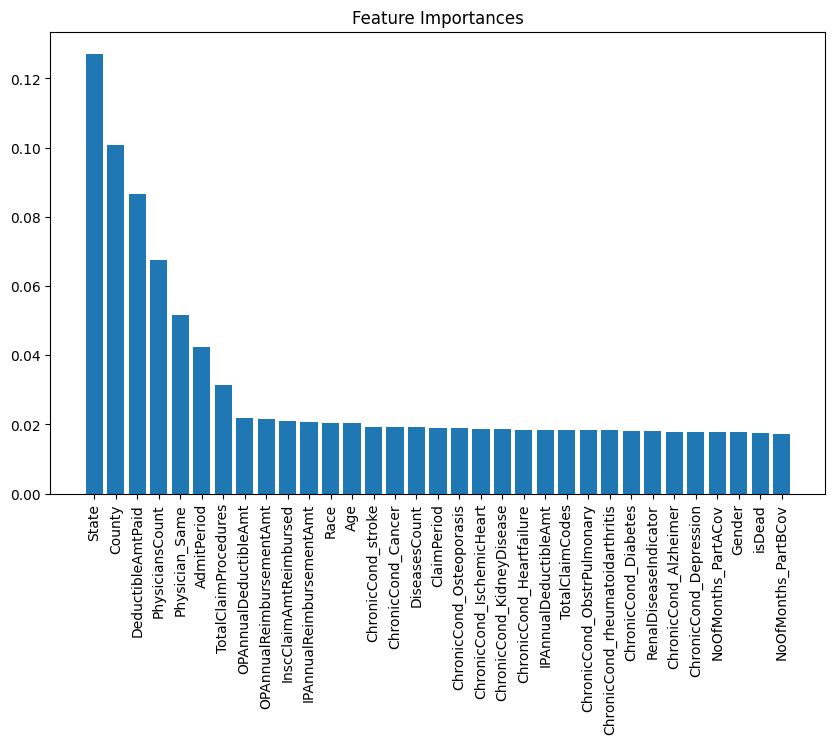

In [51]:
# get the most important features
features = X_train.columns
importances = xgb_model_final.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()

